In [ ]:
# conda create --name lulc python=3.11
# conda activate lulc
# conda install matplotlib seaborn scipy scikit-learn jupyter pandas ipykernel
# python -m ipykernel install --user --name lulc
# pip install transformers
# pip install torch torchvision
# pip install -U sentence-transformers
# pip install tf_keras
# pip install tensorflow

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
from PIL import Image
from transformers import ViTFeatureExtractor, ViTModel
import torch
from sentence_transformers import SentenceTransformer
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

## 1. Generate features

In [ ]:
# Suppress TensorFlow logging
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

# Function to extract features from images using VGG16
def extract_vgg16_features(img_paths):
    model = VGG16(weights='imagenet', include_top=False)
    features = []
    for img_path in img_paths:
        img = keras_image.load_img(img_path, target_size=(224, 224))
        x = keras_image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = vgg16_preprocess(x)
        feature = model.predict(x)
        features.append(feature.flatten())
    return np.array(features)

# Load models
device = "cuda" if torch.cuda.is_available() else "cpu"
vit_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k').to(device)

# Define a simple VAE
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

vae_model = VAE().to(device)

# Directory containing your images
image_dir = 'vietnam_jpg'
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]

# Extract VGG16 features for all images once
vgg16_features = extract_vgg16_features(image_paths)

# List to store image descriptions
image_descriptions = []

# Process each image in the directory
for image_path, vgg16_feature in zip(image_paths, vgg16_features):
    # Load and resize the image
    img = Image.open(image_path).convert("RGB")
    img_array = np.array(img)

    # Vision Transformer (ViT) features
    vit_inputs = vit_extractor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        vit_outputs = vit_model(**vit_inputs)
        vit_features = vit_outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy().tolist()

    # VAE features
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    img_vae = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        _, mu, _ = vae_model(img_vae.view(-1, 784))
        vae_features = mu.cpu().numpy().flatten().tolist()

    # Combine descriptions
    combined_description = {
        "image_path": image_path,
        "vgg16_features": vgg16_feature.tolist(),
        "vit_features": vit_features,
        "vae_features": vae_features
    }

    # Append to the list
    image_descriptions.append(combined_description)

# Save to CSV
df = pd.DataFrame(image_descriptions)
df.to_csv('feature_descriptions_vn.csv', index=False)

print("Feature descriptions have been saved to 'feature_descriptions_vn.csv'")

## Test case 14: This is the main experiment of the proposed framework

In [15]:
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
import umap
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from ast import literal_eval

warnings.filterwarnings('ignore')

# Load the CSV file
df = pd.read_csv('feature_descriptions_vn.csv')

# Ensure features are converted from strings to numeric arrays
df['vit_features'] = df['vit_features'].apply(lambda x: np.array(literal_eval(x), dtype=np.float32))
df['vae_features'] = df['vae_features'].apply(lambda x: np.array(literal_eval(x), dtype=np.float32))

# Check if the conversion is correct
print("ViT feature shape:", df['vit_features'][0].shape)
print("VAE feature shape:", df['vae_features'][0].shape)

# Reduce dimensions of ViT features
vit_umap = umap.UMAP(n_components=32, metric='cosine').fit_transform(np.vstack(df['vit_features']))

# Reduce dimensions of VAE features
vae_umap = umap.UMAP(n_components=32, metric='cosine').fit_transform(np.vstack(df['vae_features']))

# Combine reduced embeddings
joint_umap = np.concatenate([vit_umap, vae_umap], axis=1)

# Replace embeddings for clustering
embeddings_matrix = joint_umap


# Define the distance metric
distance_metric = 'cosine'

# Function to plot silhouette scores
def plot_silhouette(X, labels, metric, n_clusters, main_dir):
    silhouette_vals = silhouette_samples(X, labels, metric='precomputed')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i in range(n_clusters):
        c_silhouette_vals = silhouette_vals[labels == i]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)

    avg_silhouette = np.mean(silhouette_vals)
    plt.axvline(avg_silhouette, color="red", linestyle="--")
    plt.text(avg_silhouette + 0.01, -4, f'{avg_silhouette:.2f}', color="red", fontsize=8)
    plt.yticks(yticks, [f'Cluster {i+1}' for i in range(n_clusters)])
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.title(f'Silhouette plot for {n_clusters} clusters (metric: {metric})')

    # Save the plot as a PDF with DPI=300
    plt.savefig(f'{main_dir}/silhouette_plot_{metric}_{n_clusters}_clusters.pdf', dpi=300, format='pdf')
    plt.close()

# Perform clustering on the combined feature
feature_name = 'vit_and_vae'

# Clustering with UMAP
umap_model = umap.UMAP(n_neighbors=5, metric=distance_metric)
reduced_embeddings = umap_model.fit_transform(embeddings_matrix)
pairwise_dist = pairwise_distances(reduced_embeddings, metric=distance_metric)
normalized_distance_matrix = (pairwise_dist - pairwise_dist.min()) / (pairwise_dist.max() - pairwise_dist.min())

# Results list
results = []

# Loop over the range of clusters
for n_clusters in range(5, 11):  # 5 to 10 clusters
    best_silhouette_score = -1  # Initialize best score
    best_labels = None  # Track best labels for silhouette plot
    best_run_dir = None  # Track directory of best run for saving images
    
    # Run KMeans++ 100 times
    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []
    
    for run in range(100):
        kmeans = KMeans(n_clusters=n_clusters, init="k-means++", n_init=100, random_state=42 + run)
        labels = kmeans.fit_predict(normalized_distance_matrix)

        # Calculate evaluation metrics
        silhouette_avg = silhouette_score(normalized_distance_matrix, labels, metric='precomputed')
        db_index = davies_bouldin_score(normalized_distance_matrix, labels)
        ch_index = calinski_harabasz_score(normalized_distance_matrix, labels)

        # Track metrics
        silhouette_scores.append(silhouette_avg)
        davies_bouldin_scores.append(db_index)
        calinski_harabasz_scores.append(ch_index)

        # Update best silhouette score
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_labels = labels  # Keep best labels
            best_run_dir = f'vn_{feature_name}_{distance_metric}_k-means_UMAP_nclust={n_clusters}'

    # Calculate averages for 100 runs
    avg_silhouette_score = np.mean(silhouette_scores)
    avg_db_index = np.mean(davies_bouldin_scores)
    avg_ch_index = np.mean(calinski_harabasz_scores)

    # Append average results
    results.append({
        'silhouette_score': avg_silhouette_score,
        'davies_bouldin_index': avg_db_index,
        'calinski_harabasz_score': avg_ch_index
    })

    # Remove old directory if exists and create a new one for the best run
    if os.path.exists(best_run_dir):
        shutil.rmtree(best_run_dir)
    os.makedirs(best_run_dir)

    # Save the clustered data (best run)
    output_csv = f'{best_run_dir}/clustered_data_{distance_metric}_{n_clusters}.csv'
    df['Cluster'] = best_labels
    df.to_csv(output_csv, index=False)

    # Create subdirectories for each cluster
    for cluster_id in range(n_clusters):
        os.makedirs(os.path.join(best_run_dir, f'cluster_{cluster_id + 1}'), exist_ok=True)

    # Copy images to their respective cluster directories
    count = 0
    for _, row in df.iterrows():
        image_path = row['image_path']
        cluster_id = row['Cluster'] + 1  # Adding 1 to match folder naming
        dest_dir = os.path.join(best_run_dir, f'cluster_{cluster_id}')

        # Ensure the source file exists before copying
        if os.path.exists(image_path):
            try:
                shutil.copy(image_path, dest_dir)
                count += 1
            except Exception as e:
                print(f"Failed to copy {image_path} to {dest_dir}: {e}")
        else:
            print(f"Source file {image_path} does not exist.")
    print(f"Number of copied images into clusters for {n_clusters} clusters:", count)

    # Generate silhouette plot for the best clustering
    plot_silhouette(normalized_distance_matrix, best_labels, distance_metric, n_clusters, best_run_dir)

# Create a DataFrame with the final averaged results
results_df = pd.DataFrame(results)
results_df.to_csv(f'[Testcase 14]_proposed_framework.csv', index=False)

print("Images have been copied to their respective cluster directories for all configurations.")
print("Clustering evaluation metrics (averages) have been saved.")
print("Silhouette plots have been generated and saved for the best runs.")

ViT feature shape: (768,)
VAE feature shape: (60,)
Number of copied images into clusters for 5 clusters: 60
Number of copied images into clusters for 6 clusters: 60
Number of copied images into clusters for 7 clusters: 60
Number of copied images into clusters for 8 clusters: 60
Number of copied images into clusters for 9 clusters: 60
Number of copied images into clusters for 10 clusters: 60
Images have been copied to their respective cluster directories for all configurations.
Clustering evaluation metrics (averages) have been saved.
Silhouette plots have been generated and saved for the best runs.


## Test case 1: The framework using Glowworm Swarm Optimization to general cluster centers, the K-means is used for clustering

In [2]:
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, pairwise_distances
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from PIL import Image
import matplotlib.pyplot as plt
import copy
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

# Glowworm Swarm Optimization (GSO) functions
def fitness_function(cluster_center, data):
    distances = pairwise_distances(data, cluster_center.reshape(1, -1), metric='cosine')
    return -np.sum(distances ** 2)  # Sum of squared distances for better scaling

def starting_points(data, num_worms):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    return np.random.uniform(low=min_vals, high=max_vals, size=(num_worms, data.shape[1]))

def get_score(pop, data):
    return np.array([fitness_function(pop[i], data) for i in range(len(pop))])

def influence_matrix(pop, radius):
    graph = pairwise_distances(pop, metric='cosine')
    graph = (graph <= radius).astype(float) * graph
    np.fill_diagonal(graph, 0)
    return graph

def next_turn(pop, score, im, max_jitter):
    n_turn = copy.deepcopy(pop)
    num_worms, num_dimensions = pop.shape

    for i in range(num_worms):
        move = np.zeros(num_dimensions)
        for j in range(num_worms):
            if i == j or im[i][j] == 0:
                continue
            if score[i] < score[j]:
                percent_move = 1 - (im[i][j] / (-score[j]))
                move += (pop[j] - pop[i]) * percent_move / 10
        jitter = max_jitter * np.random.rand(num_dimensions) * np.random.choice([-1, 1], size=num_dimensions)
        n_turn[i] += move + jitter
        n_turn[i] = np.clip(n_turn[i], 0, 1)  # Assuming data is normalized between 0 and 1
    return n_turn

def load_images_from_folder(folder_path, size=(64, 64)):
    image_data = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(size)
                img_data = np.array(img).flatten()
                image_data.append(img_data)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    return np.array(image_data)

# GSO-related constants
nturns = 100
radius = 0.5
max_jitter = 0.05

# Load and preprocess images
folder_path = 'vietnam_jpg'
image_data = load_images_from_folder(folder_path)

# Normalize data
scaler = MinMaxScaler()
image_data = scaler.fit_transform(image_data)

# Dimensionality Reduction
pca = PCA(n_components=0.95, random_state=42)
image_data_pca = pca.fit_transform(image_data)
print(f"Original dimensions: {image_data.shape[1]}, Reduced dimensions: {image_data_pca.shape[1]}")

# Initialize results
results = []

print("Clustering using GSO and K-means with PCA...")

# Loop over cluster range
for n_clusters in range(5, 11):
    print(f"\nNumber of clusters: {n_clusters}")
    num_worms = n_clusters
    pop = starting_points(image_data_pca, num_worms)
    
    # Apply GSO
    for turn in range(nturns):
        score = get_score(pop, image_data_pca)
        im = influence_matrix(pop, radius)
        pop = next_turn(pop, score, im, max_jitter)
        if (turn + 1) % 10 == 0:
            print(f"  Completed turn {turn + 1}/{nturns}")
    
    # Apply K-means with init=pop and n_init=1
    kmeans = KMeans(n_clusters=n_clusters, init=pop, n_init=1, random_state=42)
    labels = kmeans.fit_predict(image_data_pca)
    
    # Compute metrics
    silhouette_avg = silhouette_score(image_data_pca, labels, metric='cosine')
    db_index = davies_bouldin_score(image_data_pca, labels)
    ch_index = calinski_harabasz_score(image_data_pca, labels)
    
    print(f"  Silhouette Score: {silhouette_avg:.4f}")
    print(f"  Davies-Bouldin Index: {db_index:.4f}")
    print(f"  Calinski-Harabasz Score: {ch_index:.4f}")
    
    # Append results
    results.append({
        'n_clusters': n_clusters,
        'silhouette_score': silhouette_avg,
        'davies_bouldin_index': db_index,
        'calinski_harabasz_score': ch_index
    })

# Save results
results_df = pd.DataFrame(results)
results_df.to_csv('[Testcase 1]_GSO_KMeans.csv', index=False)
print("\nClustering completed. Results saved to '[Testcase 1]_GSO_KMeans.csv'.")

Original dimensions: 12288, Reduced dimensions: 40
Clustering using GSO and K-means with PCA...

Number of clusters: 5
  Completed turn 10/100
  Completed turn 20/100
  Completed turn 30/100
  Completed turn 40/100
  Completed turn 50/100
  Completed turn 60/100
  Completed turn 70/100
  Completed turn 80/100
  Completed turn 90/100
  Completed turn 100/100
  Silhouette Score: 0.2869
  Davies-Bouldin Index: 2.0117
  Calinski-Harabasz Score: 11.3590

Number of clusters: 6
  Completed turn 10/100
  Completed turn 20/100
  Completed turn 30/100
  Completed turn 40/100
  Completed turn 50/100
  Completed turn 60/100
  Completed turn 70/100
  Completed turn 80/100
  Completed turn 90/100
  Completed turn 100/100
  Silhouette Score: 0.2447
  Davies-Bouldin Index: 2.2250
  Calinski-Harabasz Score: 9.9607

Number of clusters: 7
  Completed turn 10/100
  Completed turn 20/100
  Completed turn 30/100
  Completed turn 40/100
  Completed turn 50/100
  Completed turn 60/100
  Completed turn 70/100


## Generate ResNet50 features

In [3]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf

# Suppress TensorFlow logging
tf.get_logger().setLevel('ERROR')

def extract_resnet50_features(img_paths):
    """
    Extract features from images using ResNet50.

    Parameters:
    - img_paths (list): List of image file paths.

    Returns:
    - np.ndarray: Array of extracted features.
    """
    # Initialize ResNet50 model with pre-trained ImageNet weights, excluding the top classification layer
    model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
    
    features = []
    for img_path in img_paths:
        try:
            # Load and preprocess the image
            img = keras_image.load_img(img_path, target_size=(224, 224))
            x = keras_image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            
            # Extract features
            feature = model.predict(x)
            features.append(feature.flatten())
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            features.append(np.zeros(model.output_shape[1]))  # Append a zero vector in case of error
    return np.array(features)

def main():
    # Directory containing your images
    image_dir = 'vietnam_jpg'
    
    # Get list of image file paths
    image_paths = [
        os.path.join(image_dir, f) 
        for f in os.listdir(image_dir) 
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    
    if not image_paths:
        print(f"No images found in directory: {image_dir}")
        return
    
    print(f"Found {len(image_paths)} images. Extracting features using ResNet50...")
    
    # Extract ResNet50 features
    resnet50_features = extract_resnet50_features(image_paths)
    
    print("Feature extraction completed. Saving to CSV...")
    
    # Create a DataFrame with features
    df = pd.DataFrame(resnet50_features)
    df.insert(0, 'image_path', image_paths)  # Insert image paths as the first column
    
    # Save features to a CSV file
    output_csv = 'resnet50_features.csv'
    df.to_csv(output_csv, index=False)
    
    print(f"Features have been saved to '{output_csv}'.")

if __name__ == "__main__":
    main()

Found 60 images. Extracting features using ResNet50...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/s

## Test case 2: ResNet50 + PCA + Fuzzy c-means

In [9]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from fuzzycmeans import FCM
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore')

# Define the distance metric (FCM inherently uses cosine distance)
distance_metric = 'cosine'

# Initialize results list
all_results = []

# Load the CSV file containing ResNet50 features
df = pd.read_csv('resnet50_features.csv')
print("Data loaded successfully.")

# Check if 'image_path' column exists
if 'image_path' not in df.columns:
    raise ValueError("The CSV file must contain an 'image_path' column.")

# Separate 'image_path' and feature columns
feature_columns = [col for col in df.columns if col != 'image_path']
print(f"Number of feature columns: {len(feature_columns)}")

# Extract feature matrix
embeddings_matrix = df[feature_columns].values
print(f"Feature matrix shape: {embeddings_matrix.shape}")

# Normalize the features (Recommended for FCM)
scaler = StandardScaler()
embeddings_matrix_scaled = scaler.fit_transform(embeddings_matrix)
print("Feature matrix normalized.")

# Apply PCA to reduce dinsionality while retaining 98% of the variance
pca = PCA(n_components=2)
embeddings_matrix_pca = pca.fit_transform(embeddings_matrix_scaled)
print(f"PCA applied. Reduced feature matrix shape: {embeddings_matrix_pca.shape}")

# Define the range for the number of clusters
cluster_range = range(5, 11)  # 5 to 10 clusters

# Loop over the range of clusters
for n_clusters in cluster_range:
    print(f"\nPerforming Fuzzy C-Means clustering with {n_clusters} clusters...")
    
    # Initialize FCM
    fcm = FCM(n_clusters=n_clusters)
    
    # Fit FCM
    fcm.fit(embeddings_matrix_pca)
    
    # Get fuzzy membership degrees
    membership = fcm.u  # Shape: (n_samples, n_clusters)
    
    # Assign hard labels by choosing the cluster with the highest membership degree
    labels = np.argmax(membership, axis=1)
    
    # Calculate evaluation metrics
    silhouette_avg = silhouette_score(embeddings_matrix_pca, labels, metric=distance_metric)
    db_index = davies_bouldin_score(embeddings_matrix_pca, labels)
    ch_index = calinski_harabasz_score(embeddings_matrix_pca, labels)
    
    print(f"Silhouette Score: {silhouette_avg:.4f}")
    print(f"Davies-Bouldin Index: {db_index:.4f}")
    print(f"Calinski-Harabasz Score: {ch_index:.4f}")
    
    # Append results
    all_results.append({
        'n_clusters': n_clusters,
        'silhouette_score': silhouette_avg,
        'davies_bouldin_index': db_index,
        'calinski_harabasz_score': ch_index
    })

# Save clustering evaluation metrics to a CSV file
results_df = pd.DataFrame(all_results)
output_csv = f'[Testcase 2]_resnet50_features_cosine_FCM_PCA.csv'
results_df.to_csv(output_csv, index=False)
print(f"\nClustering evaluation metrics have been saved to '{output_csv}'.")

print("\nFuzzy C-Means clustering with PCA completed.")

Data loaded successfully.
Number of feature columns: 2048
Feature matrix shape: (60, 2048)
Feature matrix normalized.
PCA applied. Reduced feature matrix shape: (60, 2)

Performing Fuzzy C-Means clustering with 5 clusters...
Silhouette Score: 0.5451
Davies-Bouldin Index: 0.6648
Calinski-Harabasz Score: 77.6209

Performing Fuzzy C-Means clustering with 6 clusters...
Silhouette Score: 0.3031
Davies-Bouldin Index: 0.9920
Calinski-Harabasz Score: 66.4545

Performing Fuzzy C-Means clustering with 7 clusters...
Silhouette Score: 0.4368
Davies-Bouldin Index: 0.8492
Calinski-Harabasz Score: 65.7683

Performing Fuzzy C-Means clustering with 8 clusters...
Silhouette Score: 0.3704
Davies-Bouldin Index: 0.8559
Calinski-Harabasz Score: 61.7389

Performing Fuzzy C-Means clustering with 9 clusters...
Silhouette Score: 0.2887
Davies-Bouldin Index: 0.9838
Calinski-Harabasz Score: 54.9561

Performing Fuzzy C-Means clustering with 10 clusters...
Silhouette Score: 0.1066
Davies-Bouldin Index: 1.0242
Calin

## Test case 3: Using VGG16 and hierarchical clustering without UMAP and normalization

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from scipy.stats import entropy
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Load the CSV file
df = pd.read_csv('feature_descriptions_vn.csv')

# Define the distance metric
distance_metric = 'cosine'

# Initialize results list
all_results = []

# Function to plot silhouette scores
def plot_silhouette(X, labels, metric, n_clusters, main_dir, feature_name):
    silhouette_vals = silhouette_samples(X, labels, metric='precomputed')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i in range(n_clusters):
        c_silhouette_vals = silhouette_vals[labels == i]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)

    avg_silhouette = np.mean(silhouette_vals)
    plt.axvline(avg_silhouette, color="red", linestyle="--")
    plt.text(avg_silhouette + 0.01, -4, f'{avg_silhouette:.2f}', color="red", fontsize=8)
    plt.yticks(yticks, [f'Cluster {i+1}' for i in range(n_clusters)])
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.title(f'Silhouette plot for {n_clusters} clusters ({feature_name}, metric: {metric})')
    
    # Save the plot as a PDF with DPI=300
    plt.savefig(f'{main_dir}/silhouette_plot_{feature_name}_{metric}_{n_clusters}_clusters.pdf', dpi=300, format='pdf')
    plt.close()

# Loop over different features
for feature_name in ['vgg16_features']:
    print(f"Clustering using {feature_name}...")
    
    # Convert features to numpy arrays
    df[feature_name] = df[feature_name].apply(lambda x: np.array(eval(x)))
    
    # Perform clustering on the selected feature
    embeddings_matrix = np.vstack(df[feature_name].values)

    # Compute pairwise distance matrix
    pairwise_dist = pairwise_distances(embeddings_matrix, metric=distance_metric)

    results = []

    # Loop over the range of clusters
    for n_clusters in range(5, 11):  # 5 to 10 clusters
        hac = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
        labels = hac.fit_predict(pairwise_dist)

        silhouette_avg = silhouette_score(pairwise_dist, labels, metric='precomputed')
        db_index = davies_bouldin_score(pairwise_dist, labels)
        ch_index = calinski_harabasz_score(pairwise_dist, labels)

        results.append({
            'silhouette_score': silhouette_avg,
            'davies_bouldin_index': db_index,
            'calinski_harabasz_score': ch_index
        })

    # Save results for this feature
    results_df = pd.DataFrame(results)
    results_df.to_csv(f'[Testcase 3]_{feature_name}_{distance_metric}_HAC_noUMAP_noNormalization.csv', index=False)

    all_results.extend(results)

print("Clustering completed.")

Clustering using vgg16_features...
Clustering completed.


## Test case 3-2: Generate NN Painter feature

In [3]:
import os
from Orange.data import Table, Domain, StringVariable
from orangecontrib.imageanalytics.image_embedder import ImageEmbedder
import re
import numpy as np
import pandas as pd

import nest_asyncio

# Apply nest_asyncio to allow nested event loops
nest_asyncio.apply()

# Directory containing your images
image_dir = 'vietnam_jpg'
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]

# Create an Orange Table with a single StringVariable column for image paths in metas
meta_domain = Domain([], metas=[StringVariable("Image Path")])
image_table = Table.from_list(meta_domain, [[path] for path in image_paths])

# Initialize the NN Painters embedder
embedder = ImageEmbedder(model='painters')  # Use 'painters' for NN Painters

# Embed images by explicitly specifying the column
embeddings = embedder(image_table, col="Image Path")
# Initialize an empty dictionary
city_features_dict = {}

# Extract city and feature pairs
for i in range(len(embeddings[0])):
    data = str(embeddings[0][i])
    list_match = re.search(r"\[(.*?)\]", data)  # Matches content inside []
    tuple_match = re.search(r"\{(.*?)\}", data) # Matches content inside {}
    city = tuple_match[0].replace("{","").replace("}","")
    feature = np.array(list_match[0])
    print(city)
    # print(feature)
    # Add city and its features to the dictionary
    city_features_dict[city] = feature
# print(city_features_dict)

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(city_features_dict, orient='index')
df.reset_index(inplace=True)
df.columns = ['City', 'Feature']

# Save the DataFrame to a CSV file
df.to_csv("painters_features.csv", index=False)

print("Painters features saved as a CSV file!")

c:\Users\it08d\.conda\envs\eda_f2024\Lib\site-packages\PIL\Image.py:3406: DecompressionBombWarning: Image size (123943689 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


vietnam_jpg\N08E104_2020_v23.09_10m.jpg
vietnam_jpg\N08E105_2020_v23.09_10m.jpg
vietnam_jpg\N09E104_2020_v23.09_10m.jpg
vietnam_jpg\N09E105_2020_v23.09_10m.jpg
vietnam_jpg\N09E106_2020_v23.09_10m.jpg
vietnam_jpg\N10E103_2020_v23.09_10m.jpg
vietnam_jpg\N10E104_2020_v23.09_10m.jpg
vietnam_jpg\N10E105_2020_v23.09_10m.jpg
vietnam_jpg\N10E106_2020_v23.09_10m.jpg
vietnam_jpg\N10E107_2020_v23.09_10m.jpg
vietnam_jpg\N10E108_2020_v23.09_10m.jpg
vietnam_jpg\N11E105_2020_v23.09_10m.jpg
vietnam_jpg\N11E106_2020_v23.09_10m.jpg
vietnam_jpg\N11E107_2020_v23.09_10m.jpg
vietnam_jpg\N11E108_2020_v23.09_10m.jpg
vietnam_jpg\N11E109_2020_v23.09_10m.jpg
vietnam_jpg\N12E106_2020_v23.09_10m.jpg
vietnam_jpg\N12E107_2020_v23.09_10m.jpg
vietnam_jpg\N12E108_2020_v23.09_10m.jpg
vietnam_jpg\N12E109_2020_v23.09_10m.jpg
vietnam_jpg\N13E107_2020_v23.09_10m.jpg
vietnam_jpg\N13E108_2020_v23.09_10m.jpg
vietnam_jpg\N13E109_2020_v23.09_10m.jpg
vietnam_jpg\N14E107_2020_v23.09_10m.jpg
vietnam_jpg\N14E108_2020_v23.09_10m.jpg


In [4]:
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from scipy.stats import entropy
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Load the CSV file
df = pd.read_csv('painters_features.csv')
print(df.head())

# Define the distance metric
distance_metric = 'cosine'

# Function to plot silhouette scores
def plot_silhouette(X, labels, metric, n_clusters, main_dir, feature_name):
    silhouette_vals = silhouette_samples(X, labels, metric='precomputed')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i in range(n_clusters):
        c_silhouette_vals = silhouette_vals[labels == i]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)

    avg_silhouette = np.mean(silhouette_vals)
    plt.axvline(avg_silhouette, color="red", linestyle="--")
    plt.text(avg_silhouette + 0.01, -4, f'{avg_silhouette:.2f}', color="red", fontsize=8)
    plt.yticks(yticks, [f'Cluster {i+1}' for i in range(n_clusters)])
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.title(f'Silhouette plot for {n_clusters} clusters ({feature_name}, metric: {metric})')
    
    # Save the plot as a PDF with DPI=300
    plt.savefig(f'{main_dir}/silhouette_plot_{feature_name}_{metric}_{n_clusters}_clusters.pdf', dpi=300, format='pdf')
    plt.close()

df['Feature'] = df['Feature'].apply(lambda x: np.array(eval(x)))
embeddings_matrix = np.vstack(df['Feature'].values)

# Compute pairwise distance matrix
pairwise_dist = pairwise_distances(embeddings_matrix, metric=distance_metric)

results = []

# Loop over the range of clusters
for n_clusters in range(5, 11):  # 5 to 10 clusters
    hac = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    labels = hac.fit_predict(pairwise_dist)

    silhouette_avg = silhouette_score(pairwise_dist, labels, metric='precomputed')
    db_index = davies_bouldin_score(pairwise_dist, labels)
    ch_index = calinski_harabasz_score(pairwise_dist, labels)

    results.append({
        'silhouette_score': silhouette_avg,
        'davies_bouldin_index': db_index,
        'calinski_harabasz_score': ch_index
    })

# Save results for this feature
results_df = pd.DataFrame(results)
results_df.to_csv(f'[Testcase 3]_Painter_{distance_metric}.csv', index=False)

print("Clustering completed.")

                                      City  \
0  vietnam_jpg\N08E104_2020_v23.09_10m.jpg   
1  vietnam_jpg\N08E105_2020_v23.09_10m.jpg   
2  vietnam_jpg\N09E104_2020_v23.09_10m.jpg   
3  vietnam_jpg\N09E105_2020_v23.09_10m.jpg   
4  vietnam_jpg\N09E106_2020_v23.09_10m.jpg   

                                             Feature  
0  [0.105869, 0.218425, 0.425229, 0.0135298, 0.05...  
1  [0.125957, 0.241613, 0.409795, 0.00960466, 0.0...  
2  [0.12615, 0.0210251, 0.201022, 0.020336, 0.112...  
3  [0.0534857, 0.0416713, 1.20924, 0.00495531, 0....  
4  [0.133865, 0.0887285, 0.173806, 0.00440716, 0....  
Clustering completed.


## Test case 4 VAE+UMAP+K-means++

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import umap
import warnings

warnings.filterwarnings('ignore')

# Load the CSV file
df = pd.read_csv('feature_descriptions_vn.csv')

# Define the distance metric
distance_metric = 'cosine'

# Initialize results list
all_results = []

# Loop over different features
for feature_name in ['vae_features']:
    print(f"Clustering using {feature_name}...")
    
    # Convert features to numpy arrays
    df[feature_name] = df[feature_name].apply(lambda x: np.array(eval(x)))
    
    # Perform clustering on the selected feature
    embeddings_matrix = np.vstack(df[feature_name].values)

    # Reduce dimensionality with UMAP
    umap_model = umap.UMAP(n_neighbors=5, metric=distance_metric)
    reduced_embeddings = umap_model.fit_transform(embeddings_matrix)
    pairwise_dist = pairwise_distances(reduced_embeddings, metric=distance_metric)
    normalized_distance_matrix = (pairwise_dist - pairwise_dist.min()) / (pairwise_dist.max() - pairwise_dist.min())
    
    results = []

    # Loop over the range of clusters
    for n_clusters in range(5, 11):  # 5 to 10 clusters
        print(f"  Running K-Means for {n_clusters} clusters...")
        silhouette_scores = []
        davies_bouldin_scores = []
        calinski_harabasz_scores = []

        # Run KMeans 100 times
        for run in range(100):
            kmeans = KMeans(n_clusters=n_clusters, init="k-means++", n_init=100)
            labels = kmeans.fit_predict(normalized_distance_matrix)

            # Calculate evaluation metrics
            silhouette_avg = silhouette_score(normalized_distance_matrix, labels, metric='precomputed')
            db_index = davies_bouldin_score(normalized_distance_matrix, labels)
            ch_index = calinski_harabasz_score(normalized_distance_matrix, labels)

            silhouette_scores.append(silhouette_avg)
            davies_bouldin_scores.append(db_index)
            calinski_harabasz_scores.append(ch_index)

        # Compute average metrics over 100 runs
        avg_silhouette_score = np.mean(silhouette_scores)
        avg_davies_bouldin = np.mean(davies_bouldin_scores)
        avg_calinski_harabasz = np.mean(calinski_harabasz_scores)

        # Append average results for this n_clusters
        results.append({
            'silhouette_score': avg_silhouette_score,
            'davies_bouldin_index': avg_davies_bouldin,
            'calinski_harabasz_score': avg_calinski_harabasz
        })

    # Save results for this feature to a single CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(f'[Testcase 4]_{feature_name}_{distance_metric}_k-means_UMAP.csv', index=False)

    all_results.extend(results)

print("Clustering completed. Average metrics have been saved to CSV files.")

Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x000001D61BC2DD00>
Traceback (most recent call last):
  File "c:\Users\it08d\.conda\envs\eda_f2024\Lib\site-packages\llvmlite\binding\executionengine.py", line 178, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):

KeyboardInterrupt: 


Clustering using vae_features...


## Test case 5:  ViT+UMAP+K-means++

In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import umap
import warnings

warnings.filterwarnings('ignore')

# Load the CSV file
df = pd.read_csv('feature_descriptions_vn.csv')

# Define the distance metric
distance_metric = 'cosine'

# Initialize results list
all_results = []

for feature_name in ['vit_features']:
    print(f"Clustering using {feature_name}...")
    
    # Convert features to numpy arrays
    df[feature_name] = df[feature_name].apply(lambda x: np.array(eval(x)))
    
    # Perform clustering on the selected feature
    embeddings_matrix = np.vstack(df[feature_name].values)

    # Reduce dimensionality with UMAP
    umap_model = umap.UMAP(n_neighbors=5, metric=distance_metric)
    reduced_embeddings = umap_model.fit_transform(embeddings_matrix)
    pairwise_dist = pairwise_distances(reduced_embeddings, metric=distance_metric)
    normalized_distance_matrix = (pairwise_dist - pairwise_dist.min()) / (pairwise_dist.max() - pairwise_dist.min())
    
    results = []

    # Loop over the range of clusters
    for n_clusters in range(5, 11):  # 5 to 10 clusters
        print(f"  Running K-Means for {n_clusters} clusters...")
        silhouette_scores = []
        davies_bouldin_scores = []
        calinski_harabasz_scores = []

        # Run KMeans 100 times
        for run in range(100):
            kmeans = KMeans(n_clusters=n_clusters, init="k-means++", n_init=100)
            labels = kmeans.fit_predict(normalized_distance_matrix)

            # Calculate evaluation metrics
            silhouette_avg = silhouette_score(normalized_distance_matrix, labels, metric='precomputed')
            db_index = davies_bouldin_score(normalized_distance_matrix, labels)
            ch_index = calinski_harabasz_score(normalized_distance_matrix, labels)

            silhouette_scores.append(silhouette_avg)
            davies_bouldin_scores.append(db_index)
            calinski_harabasz_scores.append(ch_index)

        # Compute average metrics over 100 runs
        avg_silhouette_score = np.mean(silhouette_scores)
        avg_davies_bouldin = np.mean(davies_bouldin_scores)
        avg_calinski_harabasz = np.mean(calinski_harabasz_scores)

        # Append average results for this n_clusters
        results.append({
            'silhouette_score': avg_silhouette_score,
            'davies_bouldin_index': avg_davies_bouldin,
            'calinski_harabasz_score': avg_calinski_harabasz
        })

    # Save results for this feature to a single CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(f'[Testcase 5]_{feature_name}_{distance_metric}_k-means_UMAP.csv', index=False)

    all_results.extend(results)

print("Clustering completed. Average metrics have been saved to CSV files.")

Clustering using vit_features...
  Running K-Means for 5 clusters...
  Running K-Means for 6 clusters...
  Running K-Means for 7 clusters...
  Running K-Means for 8 clusters...
  Running K-Means for 9 clusters...
  Running K-Means for 10 clusters...
Clustering completed. Average metrics have been saved to CSV files.


## Test case 6: Without UMAP before k-means++

In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings

warnings.filterwarnings('ignore')

# Load the CSV file
df = pd.read_csv('feature_descriptions_vn.csv')

# Combine features (vit + vae) into a single vector
df['vit_and_vae'] = df.apply(lambda row: np.concatenate([
    np.array(eval(row['vit_features'])), 
    np.array(eval(row['vae_features']))
]), axis=1)

# Define the distance metric
distance_metric = 'cosine'

# Convert features to numpy arrays
embeddings_matrix = np.vstack(df['vit_and_vae'].values)

# Build distance matrix
pairwise_dist = pairwise_distances(embeddings_matrix, metric=distance_metric)
normalized_distance_matrix = (pairwise_dist - pairwise_dist.min()) / (pairwise_dist.max() - pairwise_dist.min())

# Initialize results list
results = []

feature_name = 'vit_and_vae'

# Run K-Means 100 times for each cluster size (5 to 10 clusters)
for n_clusters in range(5, 11):  # 5 to 10 clusters
    print(f"Processing {n_clusters} clusters...")
    
    silhouette_scores = []
    db_indices = []
    ch_indices = []

    for run in range(100):  # Run K-Means 100 times
        kmeans = KMeans(n_clusters=n_clusters, init="k-means++", n_init=100)
        labels = kmeans.fit_predict(normalized_distance_matrix)

        # Compute metrics
        silhouette_avg = silhouette_score(normalized_distance_matrix, labels, metric='precomputed')
        db_index = davies_bouldin_score(normalized_distance_matrix, labels)
        ch_index = calinski_harabasz_score(normalized_distance_matrix, labels)

        silhouette_scores.append(silhouette_avg)
        db_indices.append(db_index)
        ch_indices.append(ch_index)

    # Calculate average metrics
    avg_silhouette = np.mean(silhouette_scores)
    avg_db_index = np.mean(db_indices)
    avg_ch_index = np.mean(ch_indices)

    # Append average metrics to results
    results.append({
        'silhouette_score': avg_silhouette,
        'davies_bouldin_index': avg_db_index,
        'calinski_harabasz_score': avg_ch_index
    })

# Create DataFrame with results
results_df = pd.DataFrame(results)

# Save to CSV
output_file = f'[Testcase 6]_{feature_name}_{distance_metric}_k-means_noUMAP.csv'
results_df.to_csv(output_file, index=False)

print(f"Clustering average metrics have been saved to {output_file}.")

Processing 5 clusters...
Processing 6 clusters...
Processing 7 clusters...
Processing 8 clusters...
Processing 9 clusters...
Processing 10 clusters...
Clustering average metrics have been saved to [Testcase 3]_vit_features_cosine_k-means_noUMAP.csv.


## Test case 7: Without normalization before k-means++

In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import umap
import warnings

warnings.filterwarnings('ignore')

# Load the CSV file
df = pd.read_csv('feature_descriptions_vn.csv')

# Combine features (vit + vae)
df['vit_and_vae'] = df.apply(lambda row: np.concatenate([
    np.array(eval(row['vit_features'])), 
    np.array(eval(row['vae_features']))
]), axis=1)

# Define the distance metric
distance_metric = 'cosine'

# Convert embeddings into a single numpy array
embeddings_matrix = np.vstack(df['vit_and_vae'].values)

# UMAP for dimensionality reduction
print("Reducing dimensions using UMAP...")
umap_model = umap.UMAP(n_neighbors=5, metric=distance_metric)
reduced_embeddings = umap_model.fit_transform(embeddings_matrix)

# Build pairwise distance matrix
pairwise_dist = pairwise_distances(reduced_embeddings, metric=distance_metric)

# Initialize list to store results
results = []

# Loop over the range of clusters
print("Running K-Means clustering...")
for n_clusters in range(5, 11):  # 5 to 10 clusters
    print(f"Processing {n_clusters} clusters...")
    
    silhouette_scores = []
    db_indices = []
    ch_indices = []

    for run in range(100):  # Run K-Means 100 times
        kmeans = KMeans(n_clusters=n_clusters, init="k-means++", n_init=100)
        labels = kmeans.fit_predict(pairwise_dist)

        # Compute clustering metrics
        silhouette_avg = silhouette_score(pairwise_dist, labels, metric='precomputed')
        db_index = davies_bouldin_score(pairwise_dist, labels)
        ch_index = calinski_harabasz_score(pairwise_dist, labels)

        silhouette_scores.append(silhouette_avg)
        db_indices.append(db_index)
        ch_indices.append(ch_index)

    # Calculate average metrics across 100 runs
    avg_silhouette = np.mean(silhouette_scores)
    avg_db_index = np.mean(db_indices)
    avg_ch_index = np.mean(ch_indices)

    # Append average results
    results.append({
        'silhouette_score': avg_silhouette,
        'davies_bouldin_index': avg_db_index,
        'calinski_harabasz_score': avg_ch_index
    })

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv(f'[Testcase 7]_{feature_name}_{distance_metric}_k-means_UMAP_noNormalization.csv', index=False)

print(f"Clustering average metrics have been saved to {output_file}.")

Reducing dimensions using UMAP...
Running K-Means clustering...
Processing 5 clusters...
Processing 6 clusters...
Processing 7 clusters...
Processing 8 clusters...
Processing 9 clusters...
Processing 10 clusters...
Clustering average metrics have been saved to [Testcase 3]_vit_features_cosine_k-means_noUMAP.csv.


## Test case 8: Using HAC instead of k-means++

In [8]:
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from scipy.stats import entropy
import umap
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Load the CSV file
df = pd.read_csv('feature_descriptions_vn.csv')

# Combine features
df['vit_and_vae'] = df.apply(lambda row: np.concatenate([np.array(eval(row['vit_features'])), np.array(eval(row['vae_features']))]), axis=1)

# Define the distance metric
distance_metric = 'cosine'

# Initialize results list
results = []


# Function to plot silhouette scores
def plot_silhouette(X, labels, metric, n_clusters, main_dir):
    silhouette_vals = silhouette_samples(X, labels, metric='precomputed')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i in range(n_clusters):
        c_silhouette_vals = silhouette_vals[labels == i]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)

    avg_silhouette = np.mean(silhouette_vals)
    plt.axvline(avg_silhouette, color="red", linestyle="--")
    plt.text(avg_silhouette + 0.01, -4, f'{avg_silhouette:.2f}', color="red", fontsize=8)
    plt.yticks(yticks, [f'Cluster {i+1}' for i in range(n_clusters)])
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.title(f'Silhouette plot for {n_clusters} clusters (metric: {metric})')
    
    # Save the plot as a PDF with DPI=300
    plt.savefig(f'{main_dir}/silhouette_plot_{metric}_{n_clusters}_clusters.pdf', dpi=300, format='pdf')
    plt.close()

# Convert features to numpy arrays
df['vit_and_vae'] = df['vit_and_vae'].apply(np.array)

# Perform clustering on the combined feature
feature_name = 'vit_and_vae'

# Convert embeddings to numpy array
embeddings_matrix = np.vstack(df[feature_name].values)

# Clustering with UMAP
umap_model = umap.UMAP(n_neighbors=5, metric=distance_metric)
reduced_embeddings = umap_model.fit_transform(embeddings_matrix)
pairwise_dist = pairwise_distances(reduced_embeddings, metric=distance_metric)
normalized_distance_matrix = (pairwise_dist - pairwise_dist.min()) / (pairwise_dist.max() - pairwise_dist.min())

# Loop over the range of clusters
for n_clusters in range(5, 11):  # 5 to 10 clusters
    # Use Agglomerative Clustering instead of KMeans
    hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    labels = hierarchical_clustering.fit_predict(normalized_distance_matrix)

    # Compute metrics
    silhouette_avg = silhouette_score(normalized_distance_matrix, labels, metric='precomputed')
    db_index = davies_bouldin_score(normalized_distance_matrix, labels)
    ch_index = calinski_harabasz_score(normalized_distance_matrix, labels)

    results.append({
        'silhouette_score': silhouette_avg,
        'davies_bouldin_index': db_index,
        'calinski_harabasz_score': ch_index
    })

# Create a DataFrame with the results
results_df = pd.DataFrame(results)
results_df.to_csv(f'[Testcase 8]_{feature_name}_{distance_metric}_hierarchical_UMAP.csv', index=False)

print("Clustering evaluation metrics have been saved.")

Clustering evaluation metrics have been saved.


## Test case 9: VGG16+UMAP+K-means++

In [9]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import umap
import warnings

warnings.filterwarnings('ignore')

# Load the CSV file
df = pd.read_csv('feature_descriptions_vn.csv')

# Define the distance metric
distance_metric = 'cosine'

# Initialize results list
all_results = []

for feature_name in ['vgg16_features']:
    print(f"Clustering using {feature_name}...")
    
    # Convert features to numpy arrays
    df[feature_name] = df[feature_name].apply(lambda x: np.array(eval(x)))
    
    # Perform clustering on the selected feature
    embeddings_matrix = np.vstack(df[feature_name].values)

    # Reduce dimensionality with UMAP
    umap_model = umap.UMAP(n_neighbors=5, metric=distance_metric)
    reduced_embeddings = umap_model.fit_transform(embeddings_matrix)
    pairwise_dist = pairwise_distances(reduced_embeddings, metric=distance_metric)
    normalized_distance_matrix = (pairwise_dist - pairwise_dist.min()) / (pairwise_dist.max() - pairwise_dist.min())
    
    results = []

    # Loop over the range of clusters
    for n_clusters in range(5, 11):  # 5 to 10 clusters
        print(f"  Running K-Means for {n_clusters} clusters...")
        silhouette_scores = []
        davies_bouldin_scores = []
        calinski_harabasz_scores = []

        # Run KMeans 100 times
        for run in range(100):
            kmeans = KMeans(n_clusters=n_clusters, init="k-means++", n_init=100)
            labels = kmeans.fit_predict(normalized_distance_matrix)

            # Calculate evaluation metrics
            silhouette_avg = silhouette_score(normalized_distance_matrix, labels, metric='precomputed')
            db_index = davies_bouldin_score(normalized_distance_matrix, labels)
            ch_index = calinski_harabasz_score(normalized_distance_matrix, labels)

            silhouette_scores.append(silhouette_avg)
            davies_bouldin_scores.append(db_index)
            calinski_harabasz_scores.append(ch_index)

        # Compute average metrics over 100 runs
        avg_silhouette_score = np.mean(silhouette_scores)
        avg_davies_bouldin = np.mean(davies_bouldin_scores)
        avg_calinski_harabasz = np.mean(calinski_harabasz_scores)

        # Append average results for this n_clusters
        results.append({
            'silhouette_score': avg_silhouette_score,
            'davies_bouldin_index': avg_davies_bouldin,
            'calinski_harabasz_score': avg_calinski_harabasz
        })

    # Save results for this feature to a single CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(f'[Testcase 9]_{feature_name}_{distance_metric}_k-means_UMAP.csv', index=False)

    all_results.extend(results)

print("Clustering completed. Average metrics have been saved to CSV files.")

Clustering using vgg16_features...
  Running K-Means for 5 clusters...
  Running K-Means for 6 clusters...
  Running K-Means for 7 clusters...
  Running K-Means for 8 clusters...
  Running K-Means for 9 clusters...
  Running K-Means for 10 clusters...
Clustering completed. Average metrics have been saved to CSV files.


## Test case 10: Using VGG16 and hierarchical clustering without UMAP but normalizing the distance matrix

In [11]:
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.stats import entropy
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Load the CSV file
df = pd.read_csv('feature_descriptions_vn.csv')

# Define the distance metric
distance_metric = 'cosine'

# Initialize results list
all_results = []

# Function to plot silhouette scores
def plot_silhouette(X, labels, metric, n_clusters, main_dir, feature_name):
    silhouette_vals = silhouette_score(X, labels, metric='precomputed')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i in range(n_clusters):
        c_silhouette_vals = silhouette_vals[labels == i]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)

    avg_silhouette = np.mean(silhouette_vals)
    plt.axvline(avg_silhouette, color="red", linestyle="--")
    plt.text(avg_silhouette + 0.01, -4, f'{avg_silhouette:.2f}', color="red", fontsize=8)
    plt.yticks(yticks, [f'Cluster {i+1}' for i in range(n_clusters)])
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.title(f'Silhouette plot for {n_clusters} clusters ({feature_name}, metric: {metric})')
    
    # Save the plot as a PDF with DPI=300
    plt.savefig(f'{main_dir}/silhouette_plot_{feature_name}_{metric}_{n_clusters}_clusters.pdf', dpi=300, format='pdf')
    plt.close()

# Loop over different features
for feature_name in ['vgg16_features']:
    print(f"Clustering using {feature_name}...")
    
    # Convert features to numpy arrays
    df[feature_name] = df[feature_name].apply(lambda x: np.array(eval(x)))
    
    # Perform clustering on the selected feature
    embeddings_matrix = np.vstack(df[feature_name].values)

    # Compute the pairwise distance matrix
    pairwise_dist = pairwise_distances(embeddings_matrix, metric=distance_metric)
    normalized_distance_matrix = (pairwise_dist - pairwise_dist.min()) / (pairwise_dist.max() - pairwise_dist.min())

    results = []

    # Loop over the range of clusters
    for n_clusters in range(5, 11):  # 5 to 10 clusters
        # Perform Hierarchical Agglomerative Clustering
        hac = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
        labels = hac.fit_predict(normalized_distance_matrix)

        silhouette_avg = silhouette_score(normalized_distance_matrix, labels, metric='precomputed')
        db_index = davies_bouldin_score(normalized_distance_matrix, labels)
        ch_index = calinski_harabasz_score(normalized_distance_matrix, labels)

        results.append({
            'silhouette_score': silhouette_avg,
            'davies_bouldin_index': db_index,
            'calinski_harabasz_score': ch_index
        })

    # Save results for this feature
    results_df = pd.DataFrame(results)
    results_df.to_csv(f'[Testcase 10]_{feature_name}_{distance_metric}_HAC_noUMAP_normalization.csv', index=False)

    all_results.extend(results)

print("Clustering completed.")


Clustering using vgg16_features...
Clustering completed.


## Test case 11: VGG16 + UMAP + HAC +no normalization

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.stats import entropy
import umap
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Load the CSV file
df = pd.read_csv('feature_descriptions_vn.csv')

# Define the distance metric
distance_metric = 'cosine'

# Initialize results list
all_results = []

# Function to plot silhouette scores
def plot_silhouette(X, labels, metric, n_clusters, main_dir, feature_name):
    silhouette_vals = silhouette_samples(X, labels, metric='precomputed')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i in range(n_clusters):
        c_silhouette_vals = silhouette_vals[labels == i]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)

    avg_silhouette = np.mean(silhouette_vals)
    plt.axvline(avg_silhouette, color="red", linestyle="--")
    plt.text(avg_silhouette + 0.01, -4, f'{avg_silhouette:.2f}', color="red", fontsize=8)
    plt.yticks(yticks, [f'Cluster {i+1}' for i in range(n_clusters)])
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.title(f'Silhouette plot for {n_clusters} clusters ({feature_name}, metric: {metric})')
    
    # Save the plot as a PDF with DPI=300
    plt.savefig(f'{main_dir}/silhouette_plot_{feature_name}_{metric}_{n_clusters}_clusters.pdf', dpi=300, format='pdf')
    plt.close()

# Loop over different features
for feature_name in ['vgg16_features']:
    print(f"Clustering using {feature_name}...")
    
    # Convert features to numpy arrays
    df[feature_name] = df[feature_name].apply(lambda x: np.array(eval(x)))
    
    # Perform clustering on the selected feature
    embeddings_matrix = np.vstack(df[feature_name].values)

    # Clustering with UMAP
    umap_model = umap.UMAP(n_neighbors=5, metric=distance_metric)
    reduced_embeddings = umap_model.fit_transform(embeddings_matrix)
    pairwise_dist = pairwise_distances(reduced_embeddings, metric=distance_metric)
    
    results = []

    # Loop over the range of clusters (5 to 10 clusters)
    for n_clusters in range(5, 11):  # 5 to 10 clusters
        # Perform Hierarchical Agglomerative Clustering
        hac = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
        labels = hac.fit_predict(pairwise_dist)

        silhouette_avg = silhouette_score(pairwise_dist, labels, metric='precomputed')
        db_index = davies_bouldin_score(pairwise_dist, labels)
        ch_index = calinski_harabasz_score(pairwise_dist, labels)

        results.append({
            'silhouette_score': silhouette_avg,
            'davies_bouldin_index': db_index,
            'calinski_harabasz_score': ch_index
        })

    # Save results for this feature
    results_df = pd.DataFrame(results)
    results_df.to_csv(f'[Testcase 11]_{feature_name}_{distance_metric}_HAC_UMAP_noNormalization.csv', index=False)

    all_results.extend(results)

print("Clustering completed.")

KeyboardInterrupt: 

## Test case 12: VGG16 + UMAP + HAC + normalization

In [13]:
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from scipy.stats import entropy
import umap
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Load the CSV file
df = pd.read_csv('feature_descriptions_vn.csv')

# Define the distance metric
distance_metric = 'cosine'

# Initialize results list
all_results = []

# Function to plot silhouette scores
def plot_silhouette(X, labels, metric, n_clusters, main_dir, feature_name):
    silhouette_vals = silhouette_samples(X, labels, metric='precomputed')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i in range(n_clusters):
        c_silhouette_vals = silhouette_vals[labels == i]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)

    avg_silhouette = np.mean(silhouette_vals)
    plt.axvline(avg_silhouette, color="red", linestyle="--")
    plt.text(avg_silhouette + 0.01, -4, f'{avg_silhouette:.2f}', color="red", fontsize=8)
    plt.yticks(yticks, [f'Cluster {i+1}' for i in range(n_clusters)])
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.title(f'Silhouette plot for {n_clusters} clusters ({feature_name}, metric: {metric})')
    
    # Save the plot as a PDF with DPI=300
    plt.savefig(f'{main_dir}/silhouette_plot_{feature_name}_{metric}_{n_clusters}_clusters.pdf', dpi=300, format='pdf')
    plt.close()

# Loop over different features
for feature_name in ['vgg16_features']:
    print(f"Clustering using {feature_name}...")
    
    # Convert features to numpy arrays
    df[feature_name] = df[feature_name].apply(lambda x: np.array(eval(x)))
    
    # Perform clustering on the selected feature
    embeddings_matrix = np.vstack(df[feature_name].values)

    # Clustering with UMAP
    umap_model = umap.UMAP(n_neighbors=5, metric=distance_metric)
    reduced_embeddings = umap_model.fit_transform(embeddings_matrix)
    pairwise_dist = pairwise_distances(reduced_embeddings, metric=distance_metric)
    normalized_distance_matrix = (pairwise_dist - pairwise_dist.min()) / (pairwise_dist.max() - pairwise_dist.min())
    
    results = []

    # Loop over the range of clusters
    for n_clusters in range(5, 11):  # 5 to 10 clusters
        # Hierarchical Agglomerative Clustering
        hac = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
        labels = hac.fit_predict(normalized_distance_matrix)

        silhouette_avg = silhouette_score(normalized_distance_matrix, labels, metric='precomputed')
        db_index = davies_bouldin_score(normalized_distance_matrix, labels)
        ch_index = calinski_harabasz_score(normalized_distance_matrix, labels)

        results.append({
            'silhouette_score': silhouette_avg,
            'davies_bouldin_index': db_index,
            'calinski_harabasz_score': ch_index
        })

    # Save results for this feature
    results_df = pd.DataFrame(results)
    results_df.to_csv(f'[Testcase 12]_{feature_name}_{distance_metric}_HAC_UMAP_Normalization.csv', index=False)

    all_results.extend(results)

print("Clustering completed.")

Clustering using vgg16_features...
Clustering completed.


## Test case 13: VIT+VAE+UMAP+k-means++, no UMAP for each embedding of VIT and VAE

In [14]:
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
import umap
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Load the CSV file
df = pd.read_csv('feature_descriptions_vn.csv')

# Combine features
df['vit_and_vae'] = df.apply(lambda row: np.concatenate([np.array(eval(row['vit_features'])), np.array(eval(row['vae_features']))]), axis=1)

# Define the distance metric
distance_metric = 'cosine'

# Function to plot silhouette scores
def plot_silhouette(X, labels, metric, n_clusters, main_dir):
    silhouette_vals = silhouette_samples(X, labels, metric='precomputed')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i in range(n_clusters):
        c_silhouette_vals = silhouette_vals[labels == i]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)

    avg_silhouette = np.mean(silhouette_vals)
    plt.axvline(avg_silhouette, color="red", linestyle="--")
    plt.text(avg_silhouette + 0.01, -4, f'{avg_silhouette:.2f}', color="red", fontsize=8)
    plt.yticks(yticks, [f'Cluster {i+1}' for i in range(n_clusters)])
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.title(f'Silhouette plot for {n_clusters} clusters (metric: {metric})')

    # Save the plot as a PDF with DPI=300
    plt.savefig(f'{main_dir}/silhouette_plot_{metric}_{n_clusters}_clusters.pdf', dpi=300, format='pdf')
    plt.close()

# Convert features to numpy arrays
df['vit_and_vae'] = df['vit_and_vae'].apply(np.array)

# Perform clustering on the combined feature
feature_name = 'vit_and_vae'

# Convert embeddings to numpy array
embeddings_matrix = np.vstack(df[feature_name].values)

# Clustering with UMAP
umap_model = umap.UMAP(n_neighbors=5, metric=distance_metric)
reduced_embeddings = umap_model.fit_transform(embeddings_matrix)
pairwise_dist = pairwise_distances(reduced_embeddings, metric=distance_metric)
normalized_distance_matrix = (pairwise_dist - pairwise_dist.min()) / (pairwise_dist.max() - pairwise_dist.min())

# Results list
results = []

# Loop over the range of clusters
for n_clusters in range(5, 11):  # 5 to 10 clusters
    best_silhouette_score = -1  # Initialize best score
    best_labels = None  # Track best labels for silhouette plot
    best_run_dir = None  # Track directory of best run for saving images
    
    # Run KMeans++ 100 times
    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []
    
    for run in range(100):
        kmeans = KMeans(n_clusters=n_clusters, init="k-means++", n_init=100, random_state=42 + run)
        labels = kmeans.fit_predict(normalized_distance_matrix)

        # Calculate evaluation metrics
        silhouette_avg = silhouette_score(normalized_distance_matrix, labels, metric='precomputed')
        db_index = davies_bouldin_score(normalized_distance_matrix, labels)
        ch_index = calinski_harabasz_score(normalized_distance_matrix, labels)

        # Track metrics
        silhouette_scores.append(silhouette_avg)
        davies_bouldin_scores.append(db_index)
        calinski_harabasz_scores.append(ch_index)

        # Update best silhouette score
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_labels = labels  # Keep best labels
            best_run_dir = f'vn_{feature_name}_{distance_metric}_k-means_UMAP_nclust={n_clusters}'

    # Calculate averages for 100 runs
    avg_silhouette_score = np.mean(silhouette_scores)
    avg_db_index = np.mean(davies_bouldin_scores)
    avg_ch_index = np.mean(calinski_harabasz_scores)

    # Append average results
    results.append({
        'silhouette_score': avg_silhouette_score,
        'davies_bouldin_index': avg_db_index,
        'calinski_harabasz_score': avg_ch_index
    })

# Create a DataFrame with the final averaged results
results_df = pd.DataFrame(results)
results_df.to_csv(f'[Testcase 13]_{feature_name}_{distance_metric}_k-means_UMAP.csv', index=False)

print("Clustering evaluation metrics (averages) have been saved.")

Clustering evaluation metrics (averages) have been saved.


## Test case 15: clustimage HOG+K-means

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.cluster import KMeans
from clustimage import Clustimage
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# --- Settings ---
image_dir = 'vietnam_jpg'
resize_dim = (224, 224)
image_extensions = ('.jpg', '.jpeg')

img_paths = [os.path.join(image_dir, f) for f in sorted(os.listdir(image_dir))
             if f.lower().endswith(image_extensions) and os.path.isfile(os.path.join(image_dir, f))]
img_names = [os.path.basename(p) for p in img_paths]

hog_features = []

for img_path in img_paths:
    try:
        img = Image.open(img_path).convert('RGB').resize(resize_dim)
        gray = rgb2gray(np.array(img))
        feat = hog(gray, pixels_per_cell=(8,8), orientations=8, block_norm='L2-Hys', feature_vector=True)
        hog_features.append(feat)
    except Exception as e:
        print(f"Error loading {img_path}: {e}")

hog_features = np.array(hog_features)
if hog_features.shape[0] == 0:
    raise ValueError("No valid images were processed. Exiting.")

print(f"✅ Extracted HOG features with shape: {hog_features.shape}")

# --- Clustering and Evaluation as before ---
results = []

for n_clusters in range(5, 11):
    best_silhouette_score = -1
    best_labels = None
    best_run_dir = None

    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []

    for run in range(100):
        kmeans = KMeans(
            n_clusters=n_clusters,
            init="random",
            n_init=1,
            random_state=42 + run
        )
        labels = kmeans.fit_predict(hog_features)
        sil_score = silhouette_score(hog_features, labels)
        db_score = davies_bouldin_score(hog_features, labels)
        ch_score = calinski_harabasz_score(hog_features, labels)

        silhouette_scores.append(sil_score)
        davies_bouldin_scores.append(db_score)
        calinski_harabasz_scores.append(ch_score)

    results.append({
        'n_clusters': n_clusters,
        'avg_silhouette_score': np.mean(silhouette_scores),
        'avg_davies_bouldin_index': np.mean(davies_bouldin_scores),
        'avg_calinski_harabasz_score': np.mean(calinski_harabasz_scores)
    })

results_df = pd.DataFrame(results)
output_path = f'[Testcase 15]_ClustImage_HOG_k-means.csv'
results_df.to_csv(output_path, index=False)

print(f"✅ Clustering evaluation complete. Results saved to:\n{output_path}")


✅ Extracted HOG features with shape: (60, 48672)
✅ Clustering evaluation complete. Results saved to:
[Testcase 15]_ClustImage_HOG_k-means.csv


## Test case 16: clustimage PCA+K-means

In [3]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# --- Settings ---
image_dir = 'vietnam_jpg'
resize_dim = (224, 224)
n_components = 50  # Number of PCA components
image_extensions = ('.jpg', '.jpeg')

# --- Load and flatten images ---
img_paths = [os.path.join(image_dir, f) for f in sorted(os.listdir(image_dir))
             if f.lower().endswith(image_extensions) and os.path.isfile(os.path.join(image_dir, f))]
img_names = [os.path.basename(p) for p in img_paths]

img_arrays = []

for img_path in img_paths:
    try:
        img = Image.open(img_path).convert('RGB').resize(resize_dim)
        img_np = np.array(img) / 255.0  # Normalize to [0, 1]
        img_arrays.append(img_np.flatten())  # Flatten for PCA
    except Exception as e:
        print(f"Error loading {img_path}: {e}")

img_arrays = np.array(img_arrays)
if img_arrays.shape[0] == 0:
    raise ValueError("No valid images were processed. Exiting.")

# --- Apply PCA ---
pca = PCA(n_components=n_components, random_state=42)
pca_features = pca.fit_transform(img_arrays)

print(f"✅ Extracted PCA features with shape: {pca_features.shape}")

# --- Clustering and Evaluation ---
results = []

for n_clusters in range(5, 11):
    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []

    for run in range(100):
        kmeans = KMeans(
            n_clusters=n_clusters,
            init="random",
            n_init=1,
            random_state=42 + run
        )
        labels = kmeans.fit_predict(pca_features)
        sil_score = silhouette_score(pca_features, labels)
        db_score = davies_bouldin_score(pca_features, labels)
        ch_score = calinski_harabasz_score(pca_features, labels)

        silhouette_scores.append(sil_score)
        davies_bouldin_scores.append(db_score)
        calinski_harabasz_scores.append(ch_score)

    results.append({
        'n_clusters': n_clusters,
        'avg_silhouette_score': np.mean(silhouette_scores),
        'avg_davies_bouldin_index': np.mean(davies_bouldin_scores),
        'avg_calinski_harabasz_score': np.mean(calinski_harabasz_scores)
    })

results_df = pd.DataFrame(results)
output_path = f'[Testcase 16]_ClustImage_PCA50_k-means.csv'
results_df.to_csv(output_path, index=False)

print(f"✅ Clustering evaluation complete. Results saved to:\n{output_path}")


✅ Extracted PCA features with shape: (60, 50)
✅ Clustering evaluation complete. Results saved to:
[Testcase 16]_ClustImage_PCA50_k-means.csv


## Test case 17: clustimage PCA+HAC

In [4]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# --- Settings ---
image_dir = 'vietnam_jpg'
resize_dim = (224, 224)
n_components = 50
image_extensions = ('.jpg', '.jpeg')

# --- Load and preprocess images ---
img_paths = [os.path.join(image_dir, f) for f in sorted(os.listdir(image_dir))
             if f.lower().endswith(image_extensions) and os.path.isfile(os.path.join(image_dir, f))]
img_names = [os.path.basename(p) for p in img_paths]

img_arrays = []

for img_path in img_paths:
    try:
        img = Image.open(img_path).convert('RGB').resize(resize_dim)
        img_np = np.array(img) / 255.0  # Normalize to [0, 1]
        img_arrays.append(img_np.flatten())
    except Exception as e:
        print(f"Error loading {img_path}: {e}")

img_arrays = np.array(img_arrays)
if img_arrays.shape[0] == 0:
    raise ValueError("No valid images were processed. Exiting.")

# --- PCA for dimensionality reduction ---
pca = PCA(n_components=n_components, random_state=42)
pca_features = pca.fit_transform(img_arrays)

print(f"✅ Extracted PCA features with shape: {pca_features.shape}")

# --- Clustering and Evaluation ---
results = []

for n_clusters in range(5, 11):
    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []

    for run in range(10):  # Agglomerative is deterministic, fewer runs are sufficient
        clustering = AgglomerativeClustering(
            n_clusters=n_clusters,
            linkage='ward'
        )
        labels = clustering.fit_predict(pca_features)
        sil_score = silhouette_score(pca_features, labels)
        db_score = davies_bouldin_score(pca_features, labels)
        ch_score = calinski_harabasz_score(pca_features, labels)

        silhouette_scores.append(sil_score)
        davies_bouldin_scores.append(db_score)
        calinski_harabasz_scores.append(ch_score)

    results.append({
        'n_clusters': n_clusters,
        'avg_silhouette_score': np.mean(silhouette_scores),
        'avg_davies_bouldin_index': np.mean(davies_bouldin_scores),
        'avg_calinski_harabasz_score': np.mean(calinski_harabasz_scores)
    })

results_df = pd.DataFrame(results)
output_path = f'[Testcase 17]_ClustImage_ward_PCA50_agglomerative.csv'
results_df.to_csv(output_path, index=False)

print(f"✅ Agglomerative clustering complete. Results saved to:\n{output_path}")


✅ Extracted PCA features with shape: (60, 50)
✅ Agglomerative clustering complete. Results saved to:
[Testcase 17]_ClustImage_ward_PCA50_agglomerative.csv


## Line plot to compare clustering performance

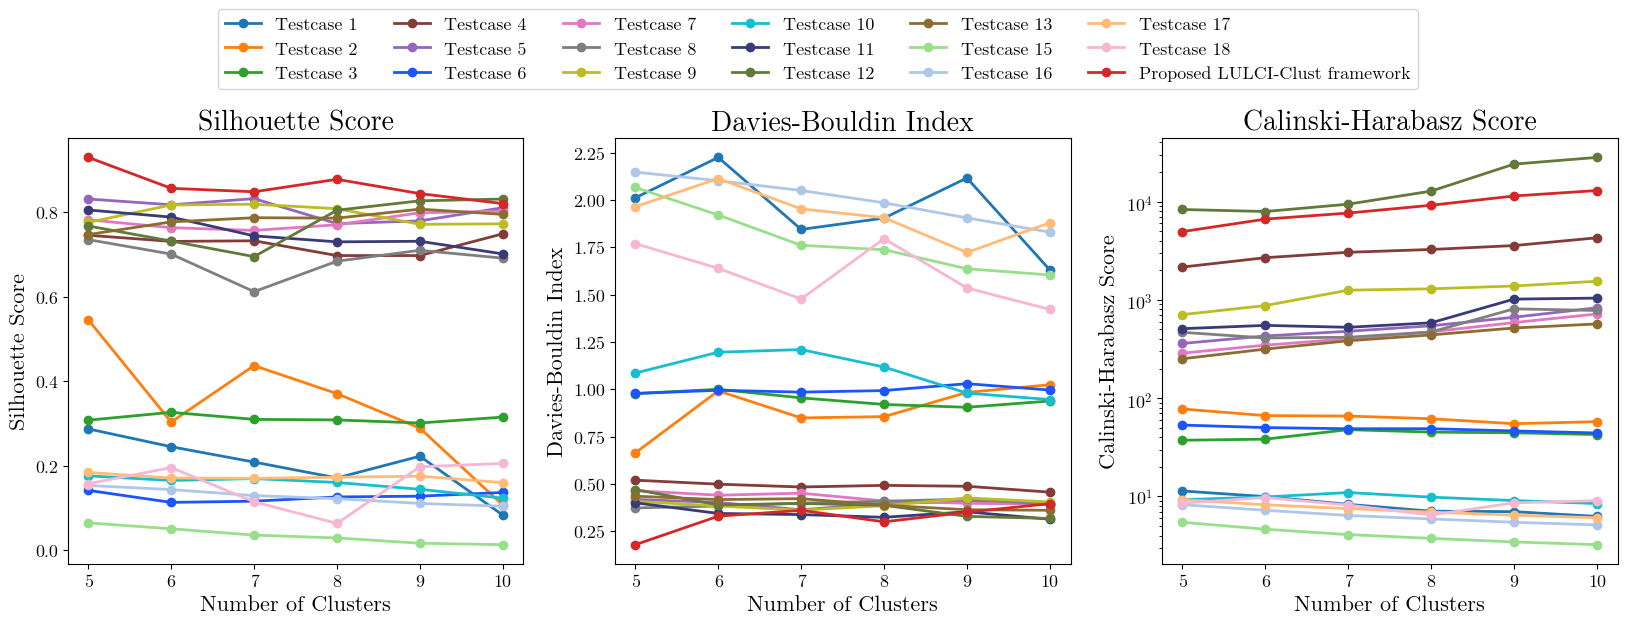

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager
import seaborn as sns

# Path to your font file
font_path = 'lmroman10-regular.otf'  # Update this path if necessary
font_prop = font_manager.FontProperties(fname=font_path)

# Data for all 18 test cases
data = {
    'n_clusters': [5, 6, 7, 8, 9, 10],
    
    'Testcase 1': {
        'silhouette_score': [0.28688342306706877, 0.2446536523293226, 0.20830416702283214, 0.17078772891028882, 0.2222302461128363, 0.08284985614973064],
        'davies_bouldin_index': [2.01173766635838, 2.225011034798127, 1.8445187335373947, 1.9044454138770215, 2.116160143335039, 1.6307819276952695],
        'calinski_harabasz_score': [11.359023663001244, 9.960729505472855, 8.305071946173292, 7.07781671107445, 6.998760420553528, 6.26256272056018]
    },
    
    'Testcase 2': {
       'silhouette_score': [0.5451197927925858, 0.30306982112507247, 0.4368399687672081, 0.3703808513994973, 0.28871769793543034, 0.10659012372787903],
        'davies_bouldin_index': [0.6647666103675194, 0.9919582346812948, 0.8491792822334252, 0.8559109262192528, 0.9837629262134122, 1.0242379454523365],
        'calinski_harabasz_score': [77.62094267120715, 66.45451491857331, 65.76830077848372, 61.73888626969351, 54.9561033284714, 57.635580374382606]

    },

    'Testcase 3': {        
        'silhouette_score': [0.3075321231524492, 0.32613686128637553, 0.3094203120446732, 0.308130418665082, 0.300839776208139, 0.31483949962363184],
        'davies_bouldin_index': [0.9775478840806027, 1.0002746436630752, 0.955030365181986, 0.9201477256004758, 0.9051767632618155, 0.9383953168573693],
        'calinski_harabasz_score': [37.311455098557786, 38.25743596030666, 47.8049402931669, 45.13131962951737, 44.404885703263666, 42.636765660515806]
    },
    
    'Testcase 4': {
        'silhouette_score': [0.74542177, 0.73084337, 0.7322946, 0.6972835, 0.69731367, 0.7487941],
        'davies_bouldin_index': [0.5202235957340049, 0.49915567695503105, 0.4842787022685172, 0.4928097188227366, 0.48807521063821674, 0.45702288793781926],
        'calinski_harabasz_score': [2158.264, 2687.7356, 3051.3162, 3257.9531, 3570.292, 4283.4673]

    },
    'Testcase 5': {
        'silhouette_score': [0.8312522, 0.81752694, 0.83212924, 0.7729413, 0.7794443, 0.81059384],
        'davies_bouldin_index': [0.4187073719283049, 0.4022485596811273, 0.36400411394953375, 0.3973611486850129, 0.40701348065680065, 0.39060393424868395],
        'calinski_harabasz_score': [360.35245, 429.38797, 479.4379, 544.7712, 665.832, 831.18646]

    },

    'Testcase 6': {
        'silhouette_score': [0.14134257894798138, 0.11285711545950437, 0.11575411215998005, 0.12579302893533584, 0.1275572891845299, 0.13637796685707276],
        'davies_bouldin_index': [0.9781810037167736, 0.9950946605666112, 0.9853102316221295, 0.9934781927771899, 1.0298039545437225, 0.9962675812183519],
        'calinski_harabasz_score': [53.21851090561836, 50.18559480704852, 48.83489625651078, 48.889966625213766, 46.40207613449314, 44.23238944144025]

    },

    'Testcase 7': {
        'silhouette_score': [0.7820001, 0.76332194, 0.7568629, 0.7701669, 0.79864854, 0.80231416],
        'davies_bouldin_index': [0.4645910787565075, 0.44093062906424096, 0.4513508845397904, 0.4105265912473456, 0.3982017492863412, 0.39378044399409085],
        'calinski_harabasz_score': [287.2483, 346.094, 402.50528, 473.24078, 587.35815, 718.859]

    },

   'Testcase 8': {
        'silhouette_score': [0.73509014, 0.70078593, 0.6118444, 0.68397534, 0.70980614, 0.69119376],
        'davies_bouldin_index': [0.37376551956922455, 0.38349219798730744, 0.3991912834007897, 0.4088533637759536, 0.42053197852657775, 0.3930782701903689],
        'calinski_harabasz_score': [467.57846, 409.81424, 416.6281, 471.47906, 810.6151, 780.5573]

    },

    'Testcase 9': {
        'silhouette_score': [0.77594095, 0.8171006, 0.81891626, 0.8083603, 0.77132064, 0.7724789],
        'davies_bouldin_index': [0.4085823294369277, 0.3838510698047811, 0.36172093816107237, 0.3853413303433429, 0.4264195444827705, 0.40519243047475867],
        'calinski_harabasz_score': [708.30963, 875.7714, 1255.7714, 1295.9503, 1385.0825, 1547.2522]
    },

    'Testcase 10': {
        'silhouette_score': [0.17563158176744156, 0.16478041089891052, 0.16924868090364187, 0.1599762474900715, 0.14390260098464103, 0.12283764276979334],
        'davies_bouldin_index': [1.0860785469004488, 1.1961266476432486, 1.210092855917652, 1.1179157574459926, 0.9800791311740648, 0.9459949937586496],
        'calinski_harabasz_score': [9.264111784658386, 9.870776610100332, 10.95533907359867, 9.83241942241808, 9.076408688243179, 8.467061776210928]

    },

    'Testcase 11': {
        'silhouette_score': [0.80526996, 0.78840667, 0.74396795, 0.7297483, 0.7311412, 0.70128906],
        'davies_bouldin_index': [0.4008551501925856, 0.3444693695519063, 0.3385693599449206, 0.3240943053556121, 0.3531340679076885, 0.3138135350064277],
        'calinski_harabasz_score': [509.3293, 550.3903, 526.0983, 584.7534, 1018.30066, 1042.5037]

    },

    'Testcase 12': {
        'silhouette_score': [0.76740175, 0.7315614, 0.69478405, 0.8046892, 0.82694805, 0.8311303],
        'davies_bouldin_index': [0.47064324833269805, 0.38972366674537223, 0.39730762562917576, 0.3873181564256713, 0.3290852020639974, 0.31803287808376235],
        'calinski_harabasz_score': [8314.976, 7929.8223, 9418.301, 12790.624, 24071.496, 28182.416]
    },

    'Testcase 13': {
        'silhouette_score': [0.74708366, 0.77704, 0.7869178, 0.7859055, 0.8072537, 0.79490036],
        'davies_bouldin_index': [0.43572559182186493, 0.41765323643686003, 0.42259366624326733, 0.38781153660275264, 0.3641680514996771, 0.36125096538669654],
        'calinski_harabasz_score': [251.71834, 315.65176, 383.77725, 440.04813, 517.72626, 569.0408]
    },

    'Proposed LULCI-Clust framework': {
      'silhouette_score': [0.9297445, 0.85653967, 0.8483167, 0.877872, 0.8440333, 0.820336],
      'davies_bouldin_index': [0.1795930633800797, 0.3300387374861921, 0.3608405137631071, 0.3003688235387996, 0.35103383025095275, 0.3963646979591651],
      'calinski_harabasz_score': [4953.4224, 6635.8076, 7649.335, 9183.284, 11410.166, 12963.655]
    },
    
    'Testcase 15': {
        'silhouette_score': [0.064336193, 0.050364527, 0.035400936, 0.028718419, 0.016165972, 0.01275045],
        'davies_bouldin_index': [2.066121064, 1.920839522, 1.76076492, 1.737411614, 1.636988136, 1.604225179],
        'calinski_harabasz_score': [5.456592217, 4.637881762, 4.088858604, 3.743144404, 3.44235543, 3.229134785]
    },

    'Testcase 16': {
        'silhouette_score': [0.1529486,0.143158029,0.12904336,0.121732155,0.110367394,0.103795865],
        'davies_bouldin_index': [2.147339929,2.102017696,2.050223292,1.985140596,1.905468478,1.830121323],
        'calinski_harabasz_score': [8.234459823,7.231544607,6.402981935,5.898176854,5.456695625,5.133705897]
    },

    'Testcase 17': {
        'silhouette_score': [0.183780487,0.17059514,0.169884359,0.172439806,0.174810922,0.159770339],
        'davies_bouldin_index': [1.964754732,2.113112952,1.953038793,1.906658936,1.722949132,1.879842629],
        'calinski_harabasz_score': [9.276959218,8.218157063,7.525331283,6.916776732,6.447724796,6.069600668]
    },

    'Testcase 18': {
        'silhouette_score': [0.157041922,0.195324168,0.114242025,0.063192062,0.197100013,0.20517619],
        'davies_bouldin_index': [1.76970596,1.639124418,1.476870165,1.795675137,1.535421094,1.422040224],
        'calinski_harabasz_score': [8.536868095,9.744116783,8.164011955,6.460808277,8.597501755,9.053609848]
    },
}
custom_colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#843c39", "#9467bd", "#1a55FF",
    "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#393b79", "#637939",
    "#8c6d31", "#98df8a", "#aec7e8", "#ffbb78", "#f7b6d2", "#d62728"  # Proposed in red
]


# List of frameworks
frameworks = [
    'Testcase 1', 'Testcase 2', 'Testcase 3', 'Testcase 4', 'Testcase 5',
    'Testcase 6', 'Testcase 7', 'Testcase 8', 'Testcase 9', 'Testcase 10',
    'Testcase 11', 'Testcase 12', 'Testcase 13', 'Testcase 15',
    'Testcase 16', 'Testcase 17', 'Testcase 18', 'Proposed LULCI-Clust framework',
]


# Create DataFrame
df = pd.DataFrame(data['n_clusters'], columns=['n_clusters'])

# Populate the DataFrame
for framework in frameworks:
    for metric in ['silhouette_score', 'davies_bouldin_index', 'calinski_harabasz_score']:
        df[f'{framework}_{metric}'] = data[framework][metric]

# Define color mapping
colors = {framework: custom_colors[i] for i, framework in enumerate(frameworks)}

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Font sizes
Large_font_prop = font_manager.FontProperties(fname=font_path, size=20)
large_font_prop = font_manager.FontProperties(fname=font_path, size=16)
small_font_prop = font_manager.FontProperties(fname=font_path, size=13)

# Metrics and titles
metrics = [
    ('silhouette_score', 'Silhouette Score', False),
    ('davies_bouldin_index', 'Davies-Bouldin Index', False),
    ('calinski_harabasz_score', 'Calinski-Harabasz Score', True)
]

# Plot each metric
for ax, (metric, title, log_scale) in zip(axes, metrics):
    for framework in frameworks:
        ax.plot(
            df['n_clusters'], 
            df[f'{framework}_{metric}'],
            marker='o',
            label=framework,
            color=colors[framework],
            linewidth=2
        )
    ax.set_title(title, fontproperties=Large_font_prop)
    ax.set_xlabel('Number of Clusters', fontproperties=large_font_prop)
    ax.set_ylabel(title, fontproperties=large_font_prop)
    ax.set_xticks([5, 6, 7, 8, 9, 10])
    ax.tick_params(axis='both', labelsize=12)

    if log_scale:
        ax.set_yscale('log')

    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(small_font_prop)

# Legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='upper center',
    ncol=6,
    prop=small_font_prop,
    bbox_to_anchor=(0.5, 1.05)
)

plt.subplots_adjust(top=0.82)
plt.savefig('clustering_comparison_vn.pdf', dpi=300, bbox_inches='tight')
plt.show()

![alt text](vietnam.jpg)

In [3]:
import os
import numpy as np
import pandas as pd
from PIL import Image

# Define color-label mapping
color_label_mapping = {
    (0, 0, 59):   "Water",
    (255, 0, 0):   "Urban/Built-up",
    (0, 127, 255): "Rice",
    (252, 195, 186): "Other Crops",
    (247, 254, 3):   "Grass/Shrub",
    (125, 254, 3):   "Woody Crops/Orchards",
    (187, 186, 184): "Barren",
    (0, 99, 0):   "Evergreen Forest",      
    (169, 219, 158): "Deciduous Forest",      
    (237, 95, 207):   "Plantation Forest",
    (136, 98, 1):   "Mangrove Forest",
    (77, 103, 252):     "Aquaculture"
}


# Directory containing your images
image_dir = 'vietnam_jpg'
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]

# Define cities for each cluster
clusters = {
    1: ["N17E105", "N18E104", "N20E104", "N21E104", "N21E106", "N22E105", "N22E106"],
    2: ["N10E104", "N10E106", "N10E107", "N11E108", "N11E109", "N15E108", "N16E107", "N17E106", "N18E105", "N19E105", "N20E106", "N21E107"],
    3: ["N09E105", "N10E105", "N12E108", "N14E107", "N14E108", "N15E107", "N16E106", "N19E103", "N19E104", "N20E103", "N21E102", "N22E102"],
    4: ["N11E107", "N12E106", "N12E107", "N13E107", "N13E108"],
    5: ["N08E104", "N08E105", "N09E104", "N09E106", "N13E109", "N14E109", "N17E107", "N18E106", "N19E106", "N21E108"],
    6: ["N21E103", "N23E104", "N23E105"],
    7: ["N11E105", "N11E106", "N20E105", "N21E105", "N22E103", "N22E104"],
    8: ["N10E103", "N10E108", "N12E109", "N16E108", "N20E107"],
}

# Process images for each cluster
for cluster_index, cities_to_keep in clusters.items():
    # Filter image paths for cities in the current cluster
    image_paths_filtered = [image_path for image_path in image_paths if any(city in image_path for city in cities_to_keep)]

    # List to store image descriptions
    image_descriptions = []

    # Process each image in the filtered list
    for image_path in image_paths_filtered:
        # Load and process the image
        img = Image.open(image_path).convert("RGB")
        img_array = np.array(img)

        # Generate pixel-based descriptions
        label_counts = {label: 0 for label in color_label_mapping.values()}
        for color, label in color_label_mapping.items():
            mask = np.all(img_array == np.array(color), axis=-1)
            label_counts[label] += np.sum(mask)
        pixel_description = ". ".join([f"{count} pixels of {label}" for label, count in label_counts.items() if count > 0])

        # Append to the list
        image_descriptions.append({
            "image_path": image_path,
            "pixel_description": pixel_description
        })

    # Save descriptions to a CSV file for the current cluster
    df = pd.DataFrame(image_descriptions)
    output_file = f'pixel_descriptions_cluster_{cluster_index}.csv'
    df.to_csv(output_file, index=False)
    print(f"Pixel descriptions for cluster {cluster_index} have been saved to '{output_file}'")

c:\Users\it08d\.conda\envs\eda_f2024\Lib\site-packages\PIL\Image.py:3406: DecompressionBombWarning: Image size (123943689 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Pixel descriptions for cluster 1 have been saved to 'pixel_descriptions_cluster_1.csv'
Pixel descriptions for cluster 2 have been saved to 'pixel_descriptions_cluster_2.csv'
Pixel descriptions for cluster 3 have been saved to 'pixel_descriptions_cluster_3.csv'
Pixel descriptions for cluster 4 have been saved to 'pixel_descriptions_cluster_4.csv'
Pixel descriptions for cluster 5 have been saved to 'pixel_descriptions_cluster_5.csv'
Pixel descriptions for cluster 6 have been saved to 'pixel_descriptions_cluster_6.csv'
Pixel descriptions for cluster 7 have been saved to 'pixel_descriptions_cluster_7.csv'
Pixel descriptions for cluster 8 have been saved to 'pixel_descriptions_cluster_8.csv'


C:\Users\it08d\AppData\Local\Temp\ipykernel_8276\139441626.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='reduced_embedding', data=df, palette='Set3', ax=ax)


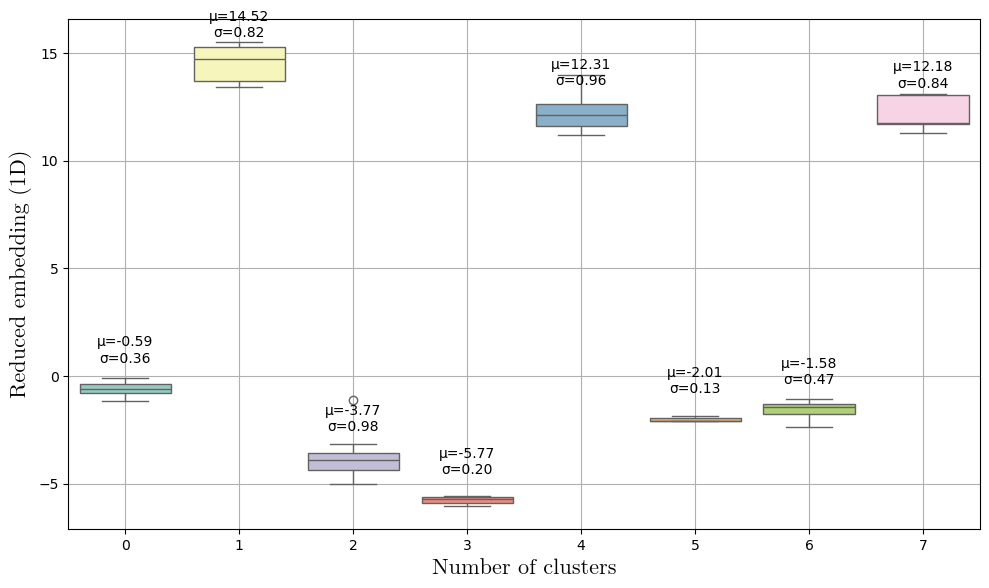

In [31]:
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import re
from matplotlib import font_manager
import random

# SEED = 0
# random.seed(SEED)
# np.random.seed(SEED)


# Load your data
df = pd.read_csv('clustered_data_cosine_8.csv')

# Clean feature strings and convert to NumPy arrays
def parse_array(s):
    s_clean = re.sub(r'(?<=[0-9])\s+(?=-?\d)', ', ', s.strip())
    return np.array(literal_eval(s_clean), dtype=np.float32)

df['vit_features'] = df['vit_features'].apply(parse_array)
df['vae_features'] = df['vae_features'].apply(parse_array)

# UMAP reduction to 32D per feature type
vit_umap = umap.UMAP(n_components=32, metric='cosine').fit_transform(
    np.vstack(df['vit_features'])
)
vae_umap = umap.UMAP(n_components=32, metric='cosine').fit_transform(
    np.vstack(df['vae_features'])
)

# Fuse ViT and VAE embeddings, then reduce to 1D
joint_umap = np.concatenate([vit_umap, vae_umap], axis=1)
final_umap = umap.UMAP(n_components=1, metric='cosine').fit_transform(joint_umap)
df['reduced_embedding'] = final_umap[:, 0]

# Font configuration
font_path = 'lmroman10-regular.otf'  # Update path if needed
font_prop = font_manager.FontProperties(fname=font_path)
Large_font_prop = font_manager.FontProperties(fname=font_path, size=20)
large_font_prop = font_manager.FontProperties(fname=font_path, size=16)
small_font_prop = font_manager.FontProperties(fname=font_path, size=13)

# Create boxplot
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Cluster', y='reduced_embedding', data=df, palette='Set3', ax=ax)

# Compute cluster statistics
cluster_stats = df.groupby('Cluster')['reduced_embedding'].agg(['mean', 'std']).reset_index()

# Option A: Offset by a fraction of the total embedding range
emb_min, emb_max = df['reduced_embedding'].min(), df['reduced_embedding'].max()
offset = (emb_max - emb_min) * 0.05

for i, row in cluster_stats.iterrows():
    y = row['mean'] + offset
    ax.text(
        i, y,
        f"μ={row['mean']:.2f}\nσ={row['std']:.2f}",
        ha='center', va='bottom', fontsize=10
    )

# # Option B: Offset by a fraction of each cluster's own std
# for i, row in cluster_stats.iterrows():
#     y = row['mean'] + row['std'] * 0.5
#     ax.text(
#         i, y,
#         f"μ={row['mean']:.2f}\nσ={row['std']:.2f}",
#         ha='center', va='bottom', fontsize=10
#     )

# Titles and labels with custom fonts
# ax.set_title("Boxplot of reduced embeddings per cluster in LULC Europe", fontproperties=Large_font_prop)
ax.set_xlabel('Number of clusters', fontproperties=large_font_prop)
ax.set_ylabel('Reduced embedding (1D)', fontproperties=large_font_prop)

plt.tight_layout()
plt.grid(True)
plt.savefig('box_plot_vn.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Build a single DataFrame with all embeddings side by side:
umap_df = pd.DataFrame(
    np.hstack([vit_umap, vae_umap, final_umap]),
    columns=[f'vit_{i+1}' for i in range(vit_umap.shape[1])]
         + [f'vae_{i+1}' for i in range(vae_umap.shape[1])]
         + ['umap_1d']
)
# Add your cluster labels back in:
umap_df['Cluster'] = df['Cluster'].values

umap_df.to_csv('all_umap_coordinates.csv', index=False)